In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Suppress annoying harmless error.
pd.options.mode.chained_assignment = None

## Unit 2 Lesson 4 Project 2 DRILL: Prepare the Data

[Download the Excel file here](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls) on crime data in New York State in 2013, provided by the FBI: UCR ([Thinkful mirror](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv)).

Prepare this data to model with multivariable regression (including data cleaning if necessary) according to this specification:

$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$

The 'population' variable is already set for you, but you will need to create the last three features.  Robbery and Murder are currently continuous variables.  For this model, please use these variables to create  categorical features where values greater than 0 are coded 1, and values equal to 0 are coded 0.  You'll use this data and model in a later assignment- for now, just write the code you need to get the data ready.  Don't forget basic data cleaning procedures, either!  Do some graphing to see if there are any anomalous cases, and decide how you want to deal with them.


In [3]:
path = ("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/" + 
       "NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv")

df = pd.read_csv(path, header=4)

In [4]:
df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0.0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,"2,577",3,0.0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,"2,846",3,0.0,NaN,0,0,3,16,1,15,0,0.0
3,Albany,"97,956",791,8.0,NaN,30,227,526,"4,090",705,"3,243",142,NaN
4,Albion Village,"6,388",23,0.0,NaN,3,4,16,223,53,165,5,NaN


In [5]:
df.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

In [6]:
df.drop(['Rape\n(revised\ndefinition)1'], axis=1, inplace=True) #column is NaN
df.replace(',','', inplace=True, regex=True)

In [7]:
crime = df[['Property\ncrime', 'Population', 'Murder and\nnonnegligent\nmanslaughter', 'Robbery']]
crime.columns = ['prop_crime', 'population', 'murder', 'robbery']

Let's see how many rows we have

In [8]:
len(crime)

351

In [9]:
print('rows with at least one nan value: {}'.format(len(crime[crime.isna().any(1)])))
print('rows with all nan value: {}'.format(len(crime[crime.isna().all(1)])))

rows with at least one nan value: 3
rows with all nan value: 3


Three rows in the dataframe have missing values (they're actually missing all values), so we're gonna drop those rows out

In [10]:
crime.dropna(inplace=True)

Make sure we don't have a value smaller than zero

In [11]:
crime.min()

prop_crime       0.0
population    1022.0
murder           0.0
robbery          0.0
dtype: float64

In [12]:
crime.dtypes

prop_crime     object
population     object
murder        float64
robbery        object
dtype: object

Trying to turn robbery data type to an integer throws an error due to dots and commas in the strings that we need to remove

In [13]:
#example
crime.robbery[35]

'1322'

In [14]:
crime.replace(',', '', inplace=True)

In [15]:
crime.robbery[35]

'1322'

In [16]:
crime.murder.dtype

dtype('float64')

In [17]:
for col in crime.columns:
    if crime[col].dtype != 'float64':
        crime[col] = crime[col].str.replace(',', '')

In [18]:
categoricals = ['murder', 'robbery']
crime = crime.astype(int)
crime[categoricals] = crime[categoricals].applymap(lambda x: 1 if x > 0 else 0)

We also have to add the squared population

In [19]:
crime.head()

,prop_crime,population,murder,robbery
0,12,1861,0,0
1,24,2577,0,0
2,16,2846,0,0
3,4090,97956,1,1
4,223,6388,0,1


### Find outliers
We're going to check for anomaly cases now

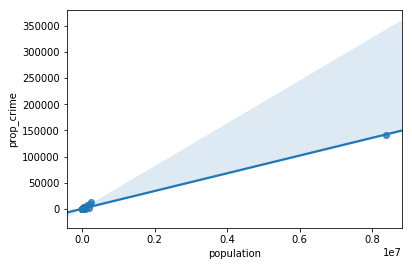

In [20]:
sns.regplot(crime.population, crime.prop_crime)
plt.show()

What we clearly see here is a lot of smaller towns and the big city NYC. Which results in a huge difference in both property crime and population, our two continous variables

We're going to apply a logaritmic transformation to reduce that gap

In [21]:
crime['pop_log'] = crime['population'].apply(lambda x: np.log(x) if x > 0 else x)
crime['prop_crime_log'] = crime['prop_crime'].apply(lambda x: np.log(x) if x > 0 else x)

In [22]:
crime.describe().round(2)

,prop_crime,population,murder,robbery,pop_log,prop_crime_log
count,348.00,348.00,348.00,348.00,348.00,348.00
mean,792.61,40037.63,0.14,0.60,8.96,4.70
std,7659.72,450037.37,0.35,0.49,1.25,1.73
min,0.00,526.00,0.00,0.00,6.27,0.00
25%,40.50,3003.00,0.00,0.00,8.01,3.70
50%,112.50,7233.50,0.00,1.00,8.89,4.72
75%,341.00,18427.50,0.00,1.00,9.82,5.83
max,141971.00,8396126.00,1.00,1.00,15.94,11.86


It looks much better now

In [23]:
pop_no_outliers = crime['pop_log'][crime['pop_log'] != max(crime['pop_log'])]
prop_no_outliers = crime['prop_crime_log'][crime['prop_crime_log'] != max(crime['prop_crime_log'])]

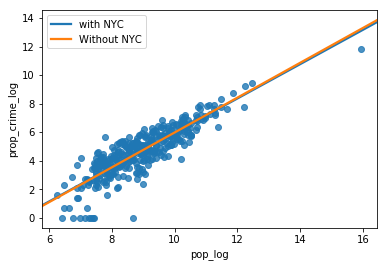

In [24]:
sns.regplot(crime.pop_log, crime.prop_crime_log, ci=None)
sns.regplot(pop_no_outliers, prop_no_outliers, scatter=False, ci=None)
plt.legend(['with NYC', 'Without NYC'])
plt.show()

the resgression line doesn't vary much with or wihtout that data point

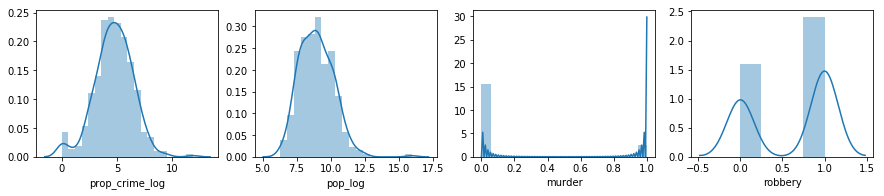

In [25]:
crime_vars = crime[['prop_crime_log', 'pop_log', 'murder', 'robbery']]

fig, ax = plt.subplots(1, 4, figsize=(15,2.7))
for var, ax in list(zip(crime_vars, ax)):
    sns.distplot(crime[var], ax=ax)
plt.show()

In [26]:
list(zip(crime_vars, ('1', '2', '2', '4')))

[('prop_crime_log', '1'), ('pop_log', '2'), ('murder', '2'), ('robbery', '4')]

In [27]:
crime['pop_log2'] = crime.pop_log**2

## Unit 2 Lesson 4 Project 4: Challenge: make your own regression model

Now that you've spent some time playing with a sample multivariate linear regression model, it's time to make your own.

You've already gotten started by prepping the FBI:UCR Crime dataset (Thinkful mirror) in a previous assignment.

Using this data, build a regression model to predict property crimes. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction rather than understanding mechanisms, so the focus is on creating a model that explains a lot of variance.

Submit a notebook with your model and a brief writeup of your feature engineering and selection process to submit and review with your mentor.


### Fit model using Sklearn

In [28]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = crime['prop_crime']
X = crime[['pop_log','pop_log2','murder', 'robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [-37386.91700087   2128.17185195  -3039.86528967    515.83278823]

Intercept: 
 161755.83074222377

R-squared:
0.7627389614365483


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


### Fit model using StatsModels

In [30]:
data = crime[['prop_crime', 'pop_log', 'pop_log2', 'murder', 'robbery']]

linear_formula = 'prop_crime ~ pop_log+pop_log2+murder+robbery'

lm = smf.ols(formula=linear_formula, data=data).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             prop_crime   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     275.7
Date:                Tue, 13 Mar 2018   Prob (F-statistic):          9.36e-106
Time:                        22:59:05   Log-Likelihood:                -3355.4
No. Observations:                 348   AIC:                             6721.
Df Residuals:                     343   BIC:                             6740.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.618e+05   6563.823     24.644      0.000    1.49e+05    1.75e+05
pop_log    -3.739e+04   1389.826    -26.900      0.000   -4.01e+04   -3.47e+04
pop_log2    2128.1719     72.374     29.405      0.000    1985.819    2270.524
murder     -3039.8653    678.664     -4.479      0.000   -4374.732   -1704.999
robbery      515.8328    521.110      0.990      0.323    -509.140    1540.806
==============================================================================
Omnibus:                      224.167   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14598.036
Skew:                           1.885   Prob(JB):                         0.00
Kurtosis:                      34.505   Cond. No.                     2.85e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Increase variance explained by model with new features

We're gonna remove Robbery from our model as it's p-value is higher than 0.05, and find another feature looking at the correlation map

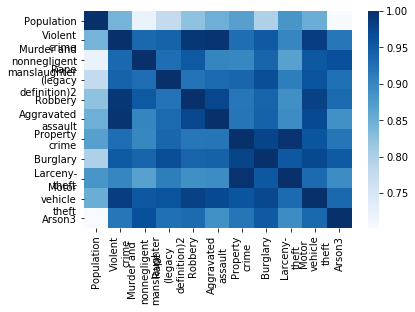

In [31]:
corr = df.dropna()
corr.loc[:, corr.columns != 'City'] = corr.loc[:, corr.columns != 'City'].astype(int)
sns.heatmap(corr.corr(), cmap="Blues")

Larcecy and property crime seem to be very correlated (in fact larcency punishes the taking of property in nonviolent face-to-face encounters)

In [52]:
crime['larceny'] = df['Larceny-\ntheft']
crime = crime.astype(int)

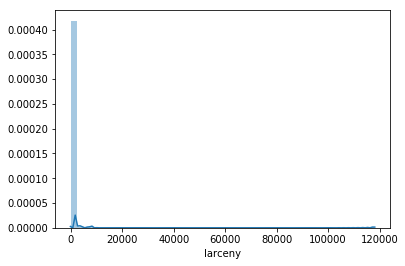

In [53]:
sns.distplot(crime.larceny)

In [54]:
crime['lar_log'] = crime['larceny'].apply(lambda x: np.log(x) if x > 0 else x)

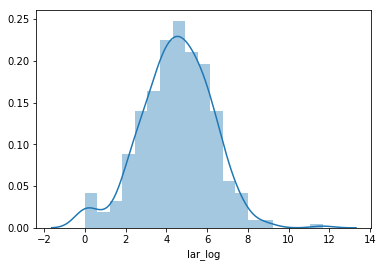

In [55]:
sns.distplot(crime.lar_log)

In [56]:
data = crime[['prop_crime', 'pop_log', 'pop_log2', 'murder', 'larceny']]

linear_formula = 'prop_crime ~ pop_log+pop_log2+murder+larceny'

lm = smf.ols(formula=linear_formula, data=data).fit()

In [57]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             prop_crime   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.491e+05
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:09:04   Log-Likelihood:                -2307.5
No. Observations:                 348   AIC:                             4625.
Df Residuals:                     343   BIC:                             4644.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    121.3233    136.707      0.887      0.375    -147.567     390.213
pop_log      -68.7446     33.197     -2.071      0.039    -134.039      -3.450
pop_log2       5.8088      1.948      2.982      0.003       1.977       9.641
murder       115.4731     33.452      3.452      0.001      49.677     181.270
larceny        1.2002      0.002    606.532      0.000       1.196       1.204
==============================================================================
Omnibus:                      578.050   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           184378.241
Skew:                           9.215   Prob(JB):                         0.00
Kurtosis:                     114.248   Cond. No.                     9.03e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looks like we're overfitting??